# EFA analysis of PheH SEC data

The data and analysis were published in:
 
*Domain movements upon activation of phenylalanine hydroxylase characterized by crystallography and chromatography-coupled small-angle X-ray scattering*

Meisburger SP, Taylor AB, Khan CA, Zhang S, Fitzpatrick PF, Ando N.

JACS 138(20): 6506?16 (2016). http://dx.doi.org/10.1021/jacs.6b01563

In [1]:
%matplotlib inline

import sys
import os
sys.path.append(os.path.abspath('../python/'))

import h5py
import numpy as np

from regals import *
from efa import *

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Load data

In [2]:
PheH_0phe_SEC = {}
with h5py.File('data/PheH_0phe_SEC.mat', 'r') as f:
    for key in f:
        PheH_0phe_SEC[key] = np.array(f[key])

#Store raw data
q = PheH_0phe_SEC['q'][0]
I = PheH_0phe_SEC['I'].T
sigma = PheH_0phe_SEC['sigma'].T
x = np.arange(I.shape[1])

## Create EFA object

In [3]:
E = efa(I, sigma)

## Calculate evolving factors

In [4]:
sr = E.evolving_factors(7,'reverse',3)
sf = E.evolving_factors(7,'forward',3)

## Automatically determine inflection points

In [5]:
xr = E.fit_inflection(sr,'reverse',1.1,30)[0]
xf = E.fit_inflection(sf,'forward',1.1,30)[0]

# put in first-in, first-out order
xf = np.sort(xf);
xr = np.sort(xr);

# get rid of extra components (those with no inflection)
is_incl = np.logical_and(np.logical_not(np.isnan(xf)),np.logical_not(np.isnan(xr)))
xf = xf[is_incl]
xr = xr[is_incl] 

ncomp = len(xf) # number of components

print(' Start  Stop\n------ ------')
for xfi, xri in zip(xf,xr):
    print('%.2f %.2f'%(xfi,xri))

 Start  Stop
------ ------
142.49 193.82
161.00 352.59
316.63 374.88


## Plot results

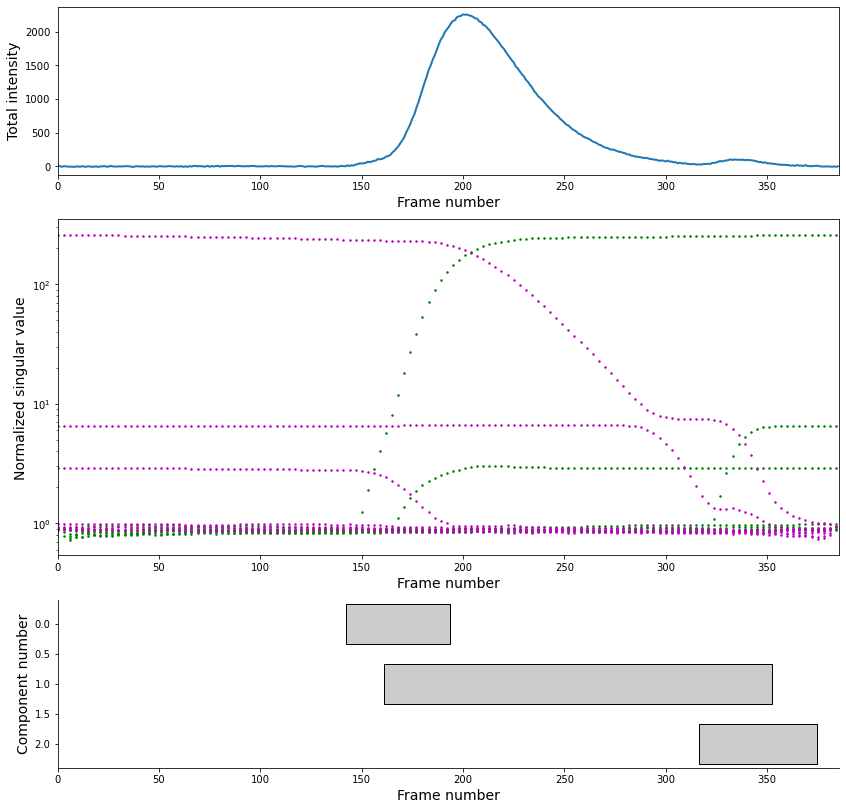

In [6]:
plt.rcParams['figure.figsize'] = 14, 14
fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 2, 1]})
xrange = [0,E.Nc-0.5]

axs[0].plot(np.sum(E.I,0), linewidth=2)
axs[0].set_xlabel('Frame number', fontsize=14)
axs[0].set_ylabel('Total intensity', fontsize=14)
axs[0].set_xlim(xrange[0],xrange[1])

axs[1].semilogy(sf.T, marker = '.', markersize = 3, color = 'g')
axs[1].semilogy(sr.T, marker = '.', markersize = 3, color = 'm')
axs[1].set_xlabel('Frame number', fontsize=14)
axs[1].set_ylabel('Normalized singular value', fontsize=14)
axs[1].set_xlim(xrange[0],xrange[1])

for j in range(ncomp):
    axs[2].add_patch(Rectangle((xf[j],j -0.33), xr[j]-xf[j], 0.66, facecolor=(0.8,0.8,0.8), edgecolor = (0,0,0)))
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
axs[2].set_xlim(xrange[0],xrange[1])
axs[2].set_ylim(ncomp-0.6,-0.4)
axs[2].set_xlabel('Frame number', fontsize=14)
axs[2].set_ylabel('Component number', fontsize=14)

plt.show()

## Quick basis rotation

In [7]:
[y,c,R] = E.quick_rotate(xf,xr)

print(R)

[[ -2.38760355 -20.42695662  -0.10699812]
 [  0.26406626   0.34302905 -10.10782644]
 [  7.45185322  -0.59910726   0.29264952]]


## Plot results

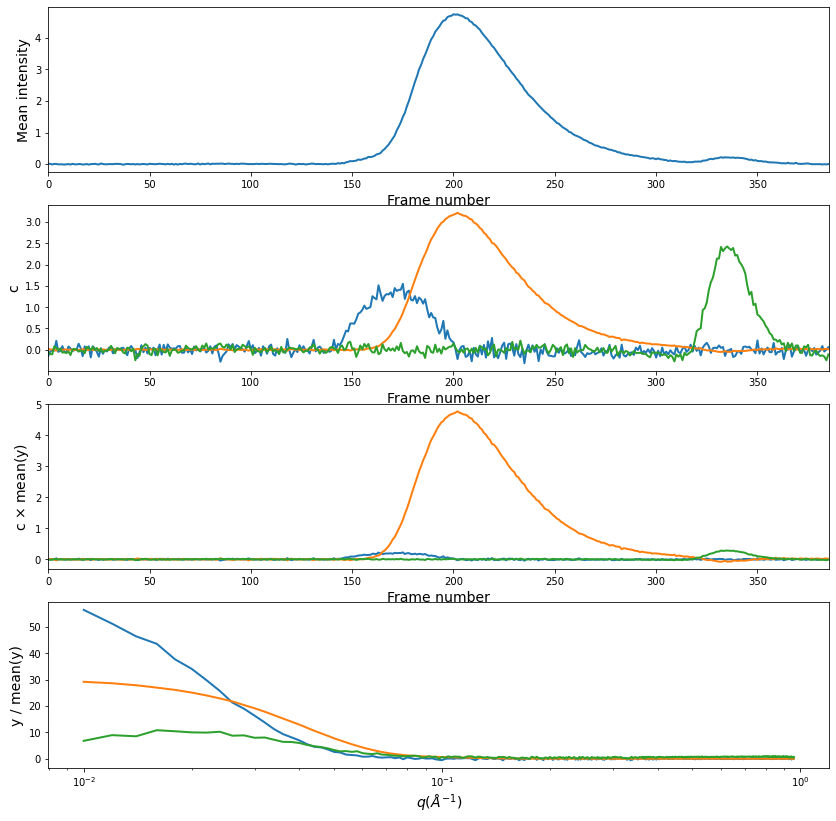

In [8]:
plt.rcParams['figure.figsize'] = 14, 14
fig, axs = plt.subplots(4, 1)
xrange = [0,E.Nc-0.5]

total_intensity = np.mean(y,0)

axs[0].plot(np.mean(E.I,0), linewidth=2)
axs[0].set_xlabel('Frame number', fontsize=14)
axs[0].set_ylabel('Mean intensity', fontsize=14)
axs[0].set_xlim(xrange[0],xrange[1])

axs[1].plot(c.T, linewidth=2)
axs[1].set_xlabel('Frame number', fontsize=14)
axs[1].set_ylabel('c', fontsize=14)
axs[1].set_xlim(xrange[0],xrange[1])

axs[2].plot(c.T * total_intensity, linewidth=2)
axs[2].set_xlabel('Frame number', fontsize=14)
axs[2].set_ylabel(r'c $\times$ mean(y)', fontsize=14)
axs[2].set_xlim(xrange[0],xrange[1])

axs[3].semilogx(q, y / total_intensity, linewidth=2)
axs[3].set_xlabel('$q (Å^{-1})$', fontsize=14)
axs[3].set_ylabel('y / mean(y)', fontsize=14)

plt.show()

## Refine using ALS, inspect chi-squared

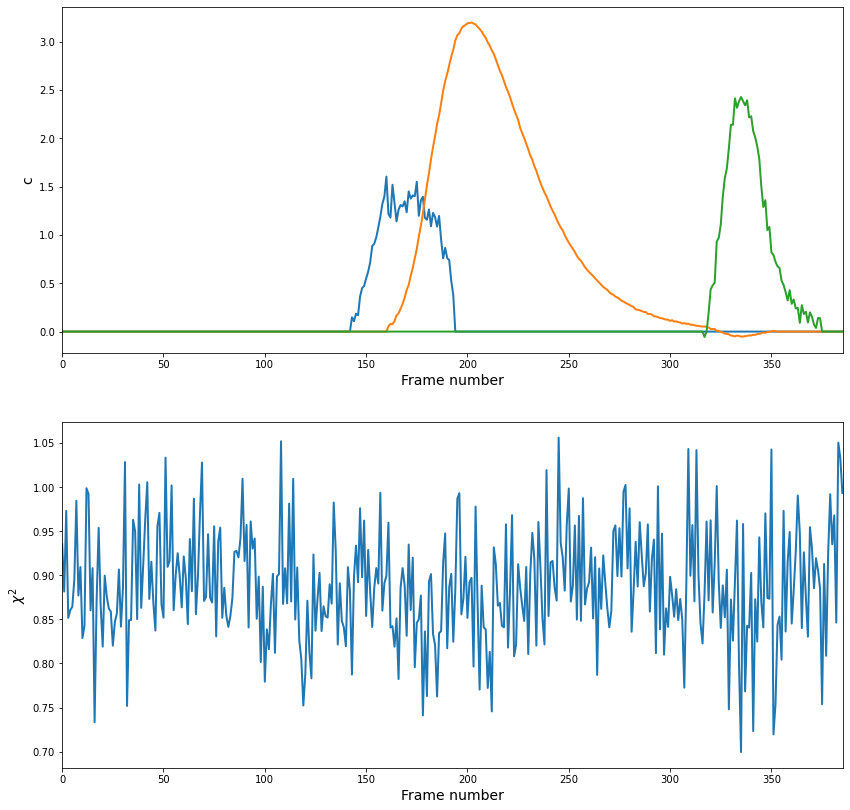

In [9]:
x = np.arange(I.shape[1])

# set up components for ALS
C = [component(concentration_class('simple',x,xmin,xmax),profile_class('simple',q)) for xmin, xmax in zip(xf,xr)]

# initialize Mixture with result from quickRotate
M = mixture(C)
M.u_profile = [y[:,j] for j in range(len(xf))]
R = regals(I,sigma)
M = R.fit_concentrations(M)

# look at residual
resid = (I - M.I_reg)/sigma

# plot the results

plt.rcParams['figure.figsize'] = 14, 14
fig, axs = plt.subplots(2, 1)
xrange = [0,E.Nc-0.5]

axs[0].plot(M.concentrations, linewidth=2)
axs[0].set_xlabel('Frame number', fontsize=14)
axs[0].set_ylabel('c', fontsize=14)
axs[0].set_xlim(xrange[0],xrange[1])

axs[1].plot(np.mean(resid**2,0), linewidth=2)
axs[1].set_xlabel('Frame number', fontsize=14)
axs[1].set_ylabel('$\chi^2$', fontsize=14)
axs[1].set_xlim(xrange[0],xrange[1])

plt.show()

## Run several iterations of ALS to fully converge result

In [10]:
# set stopFun to return true when 50 iterations is exceeded
stop_fun = lambda num_iter, params: [num_iter >= 50, 'max_iter']

update_fun = lambda num_iter, mix, params,resid: \
    print('%2d, x2 = %f, delta_profile = %s'%(num_iter,params['x2'],np.array2string(params['delta_profile'],precision=3)))

# run for 50 iterations
[M1,params,resid,exit_cond] = R.run(M, stop_fun, update_fun);

 1, x2 = 0.887709, delta_profile = [ 17.243 593.533 206.584]
 2, x2 = 0.887628, delta_profile = [0.899 0.007 2.99 ]
 3, x2 = 0.887570, delta_profile = [6.780e-01 2.355e-03 2.842e+00]
 4, x2 = 0.887524, delta_profile = [0.534 0.003 2.701]
 5, x2 = 0.887486, delta_profile = [4.274e-01 2.501e-03 2.569e+00]
 6, x2 = 0.887452, delta_profile = [3.452e-01 2.023e-03 2.447e+00]
 7, x2 = 0.887423, delta_profile = [2.807e-01 1.623e-03 2.333e+00]
 8, x2 = 0.887396, delta_profile = [2.294e-01 1.308e-03 2.226e+00]
 9, x2 = 0.887371, delta_profile = [1.883e-01 1.060e-03 2.126e+00]
10, x2 = 0.887349, delta_profile = [1.550e-01 8.643e-04 2.031e+00]
11, x2 = 0.887327, delta_profile = [1.280e-01 7.080e-04 1.943e+00]
12, x2 = 0.887307, delta_profile = [1.060e-01 5.823e-04 1.859e+00]
13, x2 = 0.887288, delta_profile = [8.787e-02 4.805e-04 1.781e+00]
14, x2 = 0.887270, delta_profile = [7.297e-02 3.977e-04 1.707e+00]
15, x2 = 0.887252, delta_profile = [6.068e-02 3.300e-04 1.637e+00]
16, x2 = 0.887236, delta_

## Plot the end results

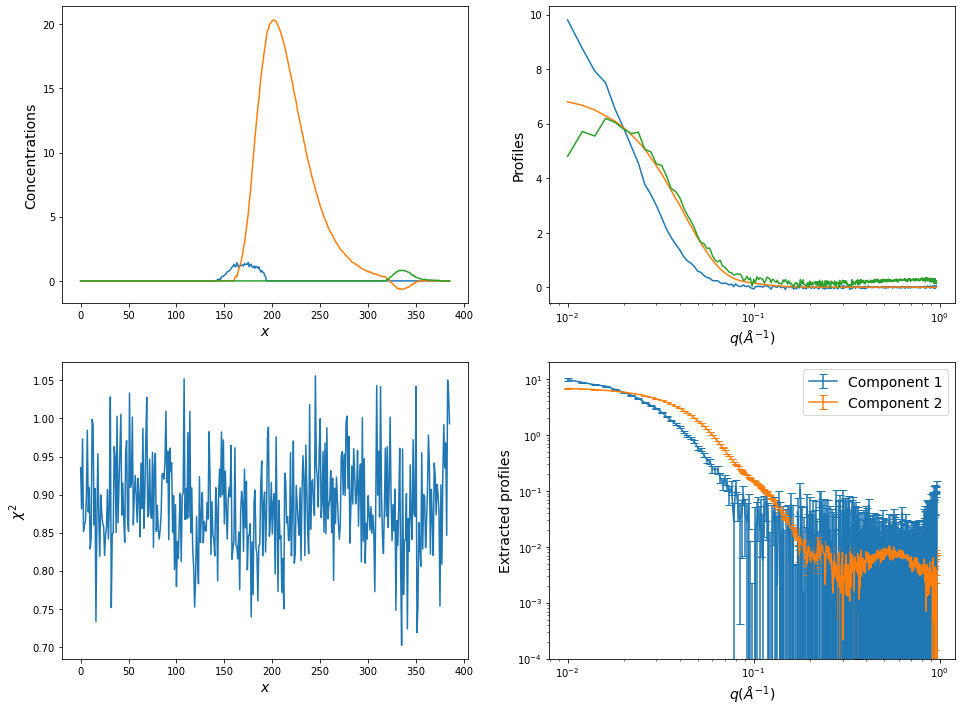

In [11]:
# extract the two particle components (no regularization)
[I1,sigma1] = M1.extract_profile(I,sigma,0);
[I2,sigma2] = M1.extract_profile(I,sigma,1);

plt.rcParams['figure.figsize'] = 16, 12
fig, axs = plt.subplots(2, 2)

#peaks vs x
axs[0, 0].plot(x, M1.concentrations)
axs[0, 0].set_xlabel('$x$', fontsize=14)
axs[0, 0].set_ylabel('Concentrations', fontsize=14)

#chi2 vs x
axs[1, 0].plot(x, np.mean(resid ** 2, 0))
axs[1, 0].set_xlabel('$x$', fontsize=14)
axs[1, 0].set_ylabel('$\chi^2$', fontsize=14)

#profiles vs q
axs[0, 1].semilogx(q, M1.profiles)
axs[0, 1].set_xlabel('$q (Å^{-1})$', fontsize=14)
axs[0, 1].set_ylabel('Profiles', fontsize=14)

#extracted profiles
axs[1, 1].errorbar(q, I1, sigma1, capsize=4, label='Component 1')
axs[1, 1].errorbar(q, I2, sigma2, capsize=4, label='Component 2')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_ylim(1E-4,2E1)
axs[1, 1].set_xlabel('$q (Å^{-1})$', fontsize=14)
axs[1, 1].set_ylabel('Extracted profiles', fontsize=14)
plt.legend(fontsize=14)

plt.show()